In [1]:
import tensorflow as tf
import pickle
import numpy as np
from tensorflow.python.framework import ops

In [2]:
gHidden1OutputSize = 20
pHidden1OutputSize = 50
sHidden1OutputSize = 50
hidden2OutputSize = 1
seed = 0
batchSize = 10

In [3]:
##MUST GET RANK OF EACH BOARD

In [4]:


inputFile = 'features.pckl'
with open(inputFile, 'rb') as fid:
    features = pickle.load(fid)
    globalFeatures = np.array([feature['globalFeatures'] for feature in features], dtype='float32')
    pieceFeatures  = np.array([feature['pieceFeatures'] for feature in features], dtype='float32')
    squareFeatures = np.array([feature['squareFeatures'] for feature in features], dtype='float32')
    ranks = np.array([feature['moveRankings'] for feature in features], dtype='float32')
    labels = np.array([feature['labels'] for feature in features], dtype='float32')

    globalLength= globalFeatures.shape[1]
    pieceLength = pieceFeatures.shape[1]
    squareLength = squareFeatures.shape[1]

In [5]:
len(features)

8951

In [105]:
tf.reset_default_graph()

globalTensor = tf.convert_to_tensor(globalFeatures, dtype=tf.float32)
pieceTensor = tf.convert_to_tensor(pieceFeatures, dtype=tf.float32)
squareTensor = tf.convert_to_tensor(squareFeatures, dtype=tf.float32)
rankTensor = tf.convert_to_tensor(ranks, dtype=tf.float32)
labelTensor = tf.convert_to_tensor(labels, dtype=tf.float32)

train_input_queue = tf.train.slice_input_producer(
                                    [globalFeatures, 
                                     pieceFeatures, 
                                     squareFeatures,
                                     ranks,
                                     labels],
                                    shuffle=False)

globalBatch, pieceBatch, squareBatch, rankBatch, labelBatch = tf.train.batch(
                                    train_input_queue,
                                    batch_size=batchSize
                                    #,num_threads=1
                                    )

#global variables
with tf.variable_scope('GlobalVariables'):
   # globalFeats = tf.placeholder(tf.float32, shape=(batchSize, globalLength), name='GlobalFeatures')#1 bit (everything is really just floats)
    #global hidden layer
    gHidden1 = tf.layers.dense(globalBatch, gHidden1OutputSize, name='GlobalHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))
    #testWeights = tf.get_variable("kernel")
#piece-centric variables
with tf.variable_scope('Piece-CentricVariables'):
    #pieceFeats = tf.placeholder(tf.float32, shape=(batchSize, pieceLength), name='Piece-CentricFeatures')

    #piece-centric hidden layer
    pHidden1 = tf.layers.dense(pieceBatch, pHidden1OutputSize, name='Piece-CentricHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))

#square-centric variables
with tf.variable_scope('Sqaure-CentricVariables'):
    #squareFeats = tf.placeholder(tf.float32, shape=(batchSize, squareLength), name='Square-CentricFeatures')
    squareRankBatch = tf.concat([squareBatch, rankBatch], 1)
    #square-centric hidden layer
    sHidden1 = tf.layers.dense(squareRankBatch, sHidden1OutputSize, name='Square-CentricHiddenLayer1', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))

input2 = tf.concat([gHidden1, pHidden1, sHidden1], 1)
logits = tf.layers.dense(input2, hidden2OutputSize, name='HiddenLayer2', activation=tf.nn.relu, kernel_initializer=tf.contrib.layers.variance_scaling_initializer(seed=seed))
probability = tf.nn.sigmoid(logits)
loss = tf.losses.sigmoid_cross_entropy(labelBatch, logits) #groundTruth must be of shape [batchSize, 1]
optimizer = tf.train.AdadeltaOptimizer()
trainer = optimizer.minimize(loss)

In [106]:
globalFeatures.shape


(31, 19)

In [116]:
batchesPerEpoch = float(globalFeatures.shape[0])/batchSize
numEpochs = 5000
saveDir = '/home/rvansoelen/rbmcData/savedModels/test/'
saveFrequency = 1000
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #print sess.run( weights = tf.get_variable("GlobalVariable/kernel"))
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    lossRecord = []
    for i in range(int(numEpochs*batchesPerEpoch)):
        thisLoss = sess.run((loss, trainer))[0]
        lossRecord.append(thisLoss)
        if i % saveFrequency == 0:
            path = saveDir+'model_'+str(i)+'.ckpt'
            save_path = saver.save(sess, path)
    coord.request_stop()
    coord.join(threads)
    coord.request_stop()
    coord.join(threads)
    '''tf.saved_model.simple_save(sess,
            saveDir,
            inputs={'globalFeatures': train_input_queue[0],
                    'pieceFeatures': train_input_queue[1], 
                    'squareFeatures': train_input_queue[2],
                    'ranks' : train_input_queue[3], 
                    'labels' : train_input_queue[4]},
            outputs={"probability": probability})'''


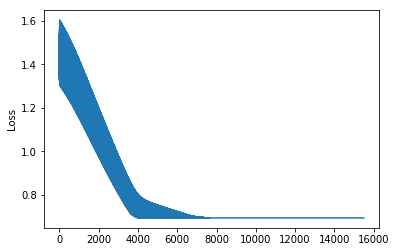

In [118]:
import matplotlib.pyplot as plt
plt.plot(lossRecord)
plt.ylabel('Loss')
plt.show()

In [99]:
with tf.Session() as sess:
    # Restore variables from disk.
    i=0
    path = saveDir+'model_'+str(i)+'.ckpt'
    saver.restore(sess, path)

INFO:tensorflow:Restoring parameters from /home/rvansoelen/rbmcData/savedModels/test/model_0.ckpt


In [ ]:
pieceFeatures